In [ ]:
#| default_exp entropy
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import diffusion_curvature
from diffusion_curvature.core import plot_3d, diffusion_matrix, gaussian_kernel
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

# Diffusion Entropy Curvature
> Anchoring Diffusion Curvature by comparison to a randomly sampled space of the same dimension

Diffusion curvature comes from a simple idea: *random walks are lazier the higher the curvature*. From this, you can see how "diffusion entropy curvature" came about: diffusions are just aggregate random walks, and entropy is one means of captiruing how "spread out" -- how "lazy" -- the diffusion is. There's additional theory; one can formulate this as a pointwise Ollivier-Ricci curvature, using the KL Divergence instead of the wasserstein distance -- but the intuition is very simple.

To convert this magnitude-of-curvature estimate to a *signed* quantity, we compute this Diffusion Entropy both on the pointcloud/graph of interest, and in a spontaneously constructed flat space of the same sampling and with a similar kernel. We then subtract the diffusion entropy on the manifold from the diffusion entropy of our flat comparison space to obtain the diffusion entropy curvature.

This notebook is a part of a suite of experiments answering the question: [Do Neural ODEs remove structure in a manner more conducive to curvature computations than pure random sampling](obsidian://advanced-uri?vault=Pumberton&uid=f3052b9e-cef0-4fb8-a4fd-fd150c7af868)?

This notebook builds the simplest answer: comparing the diffusion curvature of a the manifold to a uniform random sampling of the same dimension. 
Obviously (and unfortunately), the dimension of the manifold must be supplied.

To begin, here are the baseline functions for diffusion curvature:

In [ ]:
#| export
import numpy as np
from scipy.stats import entropy
from diffusion_curvature.core import gaussian_kernel
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
def local_diffusion_entropy_of_matrix(
    P:np.ndarray, # diffusion matrix
    t:int # time step to compute entropy at
    ) -> np.ndarray:
    """Computes the pointwise entropy of the t-step diffusion, a proxy for curvature"""
    P_t = np.linalg.matrix_power(P,t)
    entropies = np.array([entropy(x) for x in P_t])
    return entropies
def diffusion_entropy_curvature_of_data(
        X:np.ndarray, # data points, in shape n x d
        t:int=8, # time steps of diffusion
        k:int=10, # number of neighbors to use in calculating kernel
        **kwargs
        )->np.ndarray:
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    entropies = local_diffusion_entropy_of_matrix(P,t=t)
    return entropies

## Baseline: Entropy of the Torus
To compare the local diffusion entropy of a dataset with that of other spaces, we need a sense of our tolerance for deviation. How much variance in the diffusion entropy reveals the curvature? Whatever method we choose must have a lower variance between random initializations than the intra-dataset variance of the torus.

In [ ]:
from diffusion_curvature.datasets import torus
X_torus, ks_torus = torus(n=2000)
diffents_torus = diffusion_entropy_curvature_of_data(X_torus,t = 8, k=10) # using the default parameters

First, is this an accurate coloring of the torus? The colors will be inverted (low entropy -> positive curvature), but they should reveal the contour.

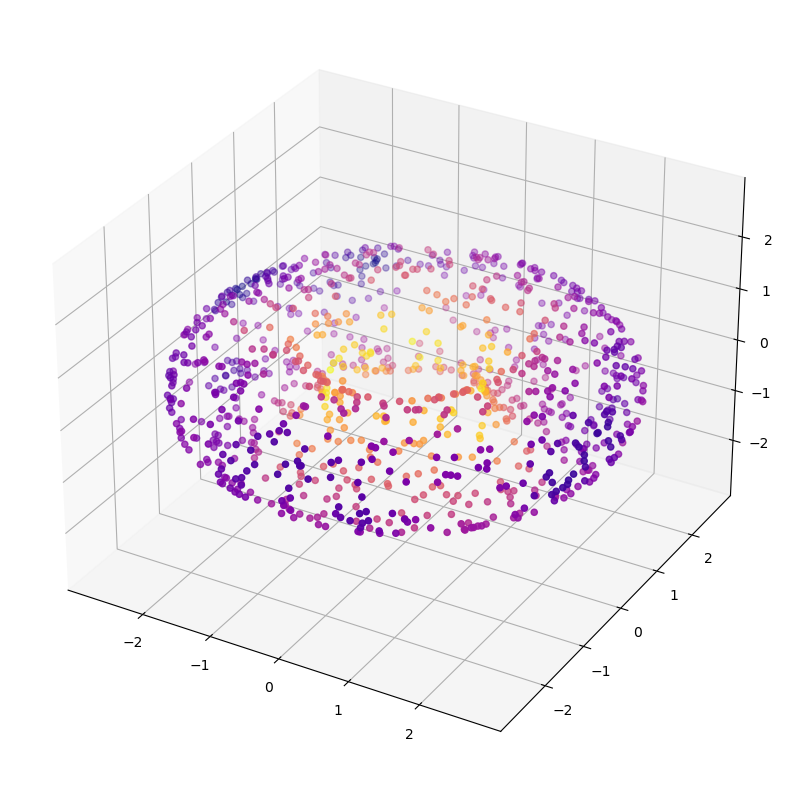

In [ ]:
plot_3d(X_torus,diffents_torus)

Variance of entropies in torus is  0.03030868053439055


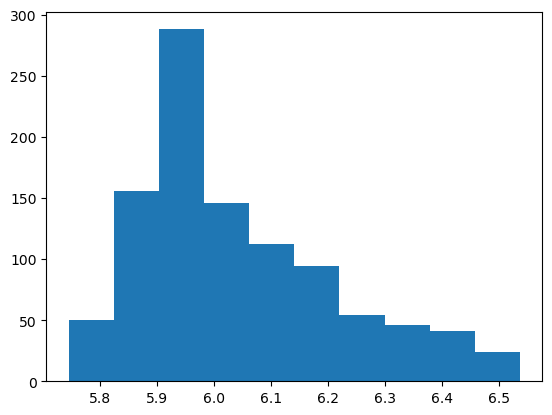

In [ ]:
plt.hist(diffents_torus)
variance_of_torus_entropies = np.var(diffents_torus)
print("Variance of entropies in torus is ", variance_of_torus_entropies)

The difference between positive and negative curvature appears to span around 0.5 log units. Any comparison method should be well below that.

# Comparisons with Uniform Random Noise

In [ ]:
#| export
def diffusion_entropy_of_noise(dimension, t, n_flat_samples) -> float:
    # construct uniform noise, with one zero point at the center
    noisy_flat = np.random.rand(n_flat_samples-1, dimension)*2 - 1
    noisy_flat = np.vstack([np.zeros(dimension),noisy_flat])
    # note that the edges of this distribution aren't trustworthy; we only care about the middle
    # so we'll take just the entropy of the random noise
    entropy_flat = diffusion_entropy_curvature_of_data(noisy_flat, t = t)
    # TODO: This is ridiculously wasteful. It computes the curvature of every point, when we only need
    # the central point.
    # At least average over some points
    return entropy_flat[0]

def diffusion_curvature_contra_noise(X, dimension, t=8, k=10) -> np.ndarray:
    k_data = diffusion_entropy_curvature_of_data(X, t=t)
    k_noise = diffusion_entropy_of_noise(dimension, t=t, n_flat_samples=len(X))
    return k_noise - k_data

## Dimensionality Analysis
Encounters with the curse of dimensionality

Let's see how the local diffusion entropy of flat noise changes as we increase the dimension

In [ ]:
# ks = []
# n_flat_samples = 10000
# for dim in tqdm([2,3,4,5,6,7]):
#     ks.append(np.mean(diffusion_entropy_of_noise(dim, t=8, n_flat_samples=n_flat_samples)))

In [ ]:
# plt.plot(ks)

It's likely that the decay observed here is caused by partially increasing mismatch between the dimension and the number of points sampled.

Also, $ln(n\_points) = ln(10000) = 9.2$ is the maximum possible entropy. We converge to this quickly.

## Testing the Variance of the Entropy of the noise
This is a test of the robustness of the diffusion entropy method. One hopes that under repetition, the  entropy measurement won't change *too* much. Let's quantify exactly how much it does change.

In [ ]:
n_tests = 500
n_samples = len(X_torus)
t = 8
ks_from_noise = []
for i in trange(n_tests):
    ks_from_noise.append(diffusion_entropy_of_noise(dimension=2, t=t, n_flat_samples=n_samples))

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

(array([  6.,  22.,  40.,  94.,  93., 109.,  71.,  41.,  17.,   7.]),
 array([5.87227446, 5.90998303, 5.9476916 , 5.98540017, 6.02310874,
        6.06081731, 6.09852588, 6.13623445, 6.17394301, 6.21165158,
        6.24936015]),
 <BarContainer object of 10 artists>)

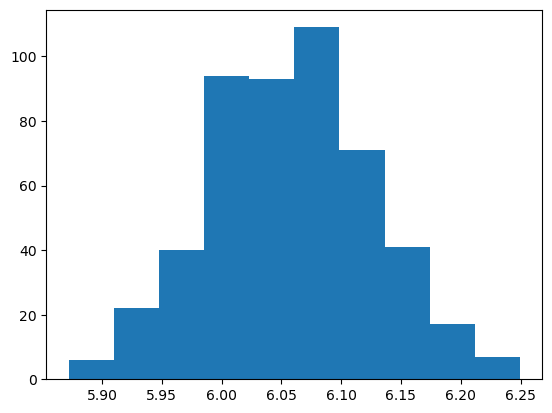

In [ ]:
plt.hist(ks_from_noise)

In [ ]:
variance_of_randomly_sampled_entropies = np.var(ks_from_noise)
print("Variance of the data is",variance_of_randomly_sampled_entropies)
print("This is",variance_of_torus_entropies/variance_of_randomly_sampled_entropies, "times less than that between the entropies of the torus")

Variance of the data is 0.004586862501379477
This is 7.282389434676444 times less than that between the entropies of the torus


This is actually low enough to be useful as a first approximation, at least within this regime of abundantly sampled data in low dimensions.

# Curvature by Comparison

In [ ]:
n = 4000
X_torus, ks_torus = torus(n=n)
num_points = n//2

In [ ]:
ks_torus_contra_noise = diffusion_curvature_contra_noise(X_torus, dimension=2,t=32)

In [ ]:
print("Lowest diffusion curvature value is ",min(ks_torus_contra_noise),"and highest is",max(ks_torus_contra_noise))

Lowest diffusion curvature value is  -0.14629362732615991 and highest is 0.2628877815426893


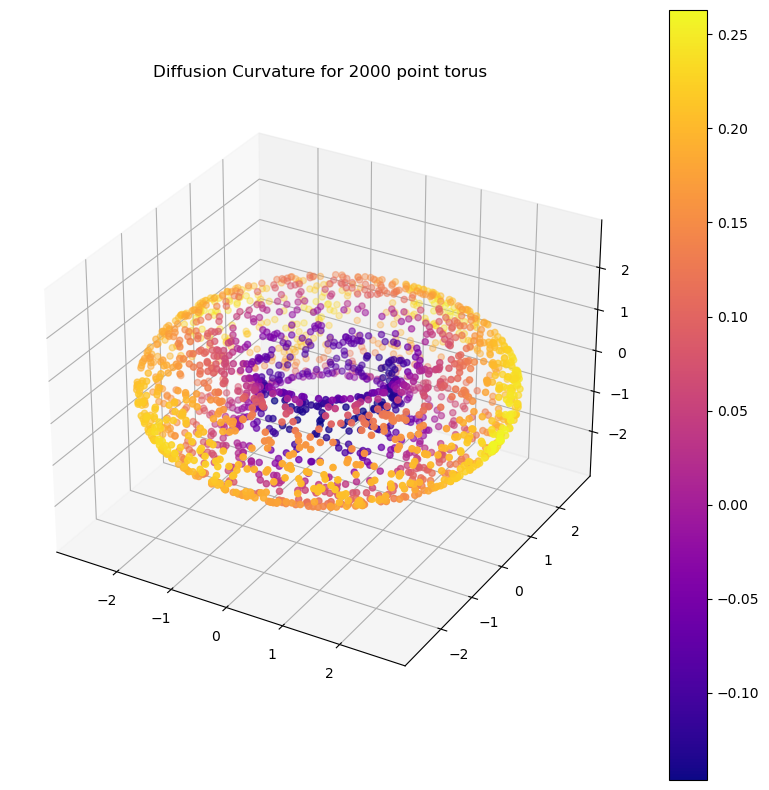

In [ ]:
plot_3d(X_torus, ks_torus_contra_noise, title = f"Diffusion Curvature for {num_points} point torus", colorbar=True)

In [ ]:
import scipy
pr = scipy.stats.pearsonr(ks_torus,ks_torus_contra_noise)
print(f"Pearson correlation between gaussian curvature and and DC")
print(pr)

Pearson correlation between gaussian curvature and and DC
PearsonRResult(statistic=0.9677879519118565, pvalue=0.0)


Compared to the real curvatures

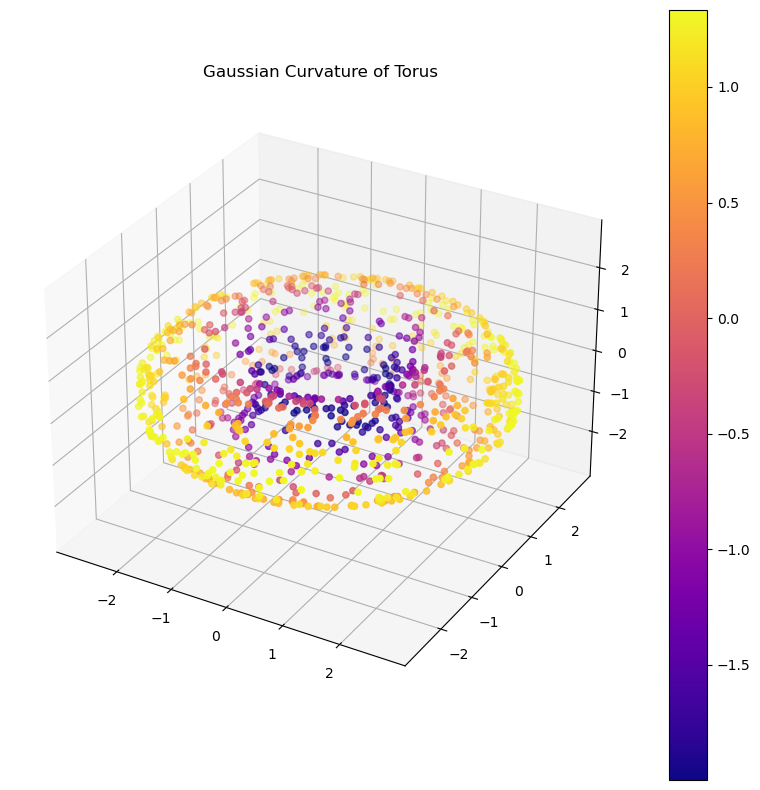

In [ ]:
plot_3d(X_torus,ks_torus,title="Gaussian Curvature of Torus",colorbar=True)

In [ ]:
print("Lowest gaussian curvature value is ",min(ks_torus),"and highest is",max(ks_torus))

Lowest gaussian curvature value is  -1.9998186489767444 and highest is 1.333333316302257


# Other Datasets

In [ ]:
from diffusion_curvature.datasets import *

In [ ]:
n = 2000
X = plane(n=n)
num_points = n
len(X)

2004

In [ ]:
ks_dc = diffusion_curvature_contra_noise(X, dimension=2,t=16)

In [ ]:
print("Lowest diffusion curvature value is ",min(ks_dc),"and highest is",max(ks_torus_contra_noise))

Lowest diffusion curvature value is  -0.04332515285183103 and highest is 0.2628877815426893


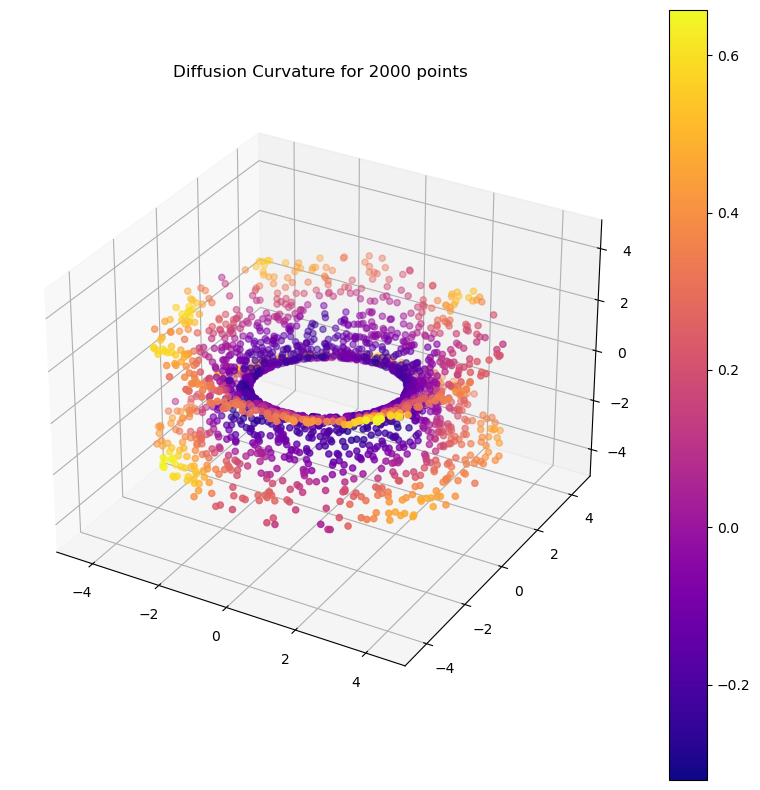

In [ ]:
plot_3d(X, ks_dc, title = f"Diffusion Curvature for {num_points} points", colorbar=True)

In [ ]:
import scipy
pr = scipy.stats.pearsonr(ks,ks_dc)
print(f"Pearson correlation between gaussian curvature and and DC")
print(pr)

Pearson correlation between gaussian curvature and and DC
PearsonRResult(statistic=0.5961116023945053, pvalue=9.798842502714188e-193)


Compared to the real curvatures

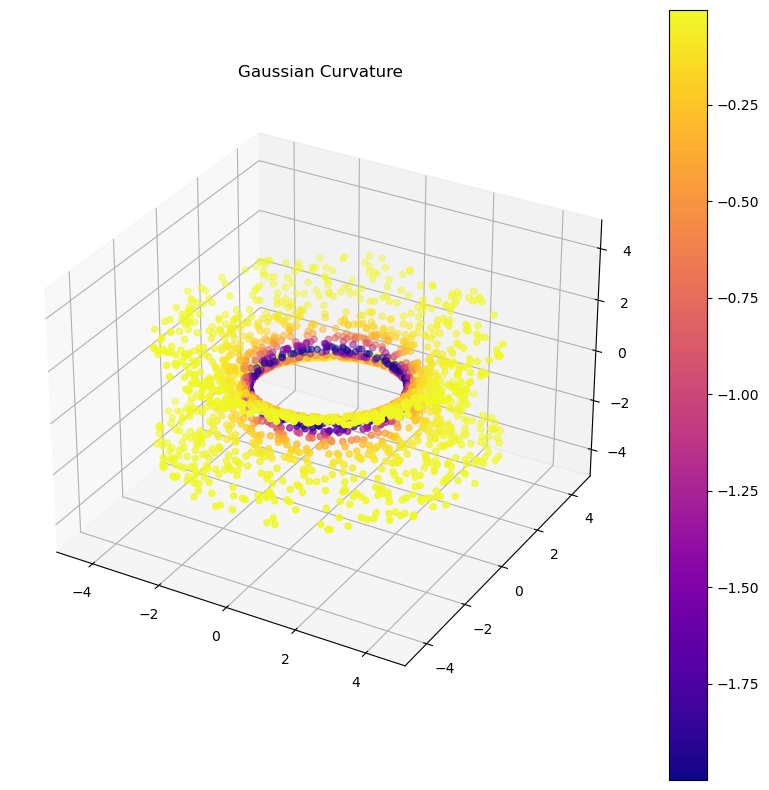

In [ ]:
plot_3d(X,ks,title="Gaussian Curvature",colorbar=True)

In [1]:
!nbdev_export